In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import time
import numpy as np
import cv2
from PIL import Image
import os
from matplotlib import pyplot as plt

#Turn all the randomisation off to ensure the results of every execution is the same 
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Define Image Dataset structure and image transform

In [2]:
IMG_SIZE = 224
FOLDER_PATH = "Images/100"

class ImageDataSet(Dataset):
    def __init__(self, image_names, transform):
        self.file_names = []
        self.labels = []
        for numeric_label, names in enumerate(image_names):
            self.labels.extend([numeric_label]*len(names))
            self.file_names.extend(names)

        self.transform = transform

    def __getitem__(self, index):
        img_name = self.file_names[index]
        img = Image.open(img_name).convert('RGB')
        img = self.transform(img)
        label = self.labels[index]
        return img, label
    
    def __len__(self):
        return len(self.file_names)

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Offically used by Pytorch
])


# labels = [folder for folder in os.listdir(FOLDER_PATH)]
labels = ["Immune_Cells", "Non_Invasive_Tumor", "Invasive_Tumor_Set"]
le = LabelEncoder()
numeric_labels = le.fit_transform(labels)
image_names = []
for _ in numeric_labels:
    image_names.append([])

for (dir_path, dir_names, file_names) in os.walk(FOLDER_PATH):
    parent_folder = os.path.basename(dir_path)
    if parent_folder in labels: # Read the subset of dataset to reduce training time 
        for file in file_names:
            image = cv2.imread(os.path.join(dir_path, file))
            if image.shape[0] < 100 and image.shape[1] < 100: #skip the small image, it doesn't give much info
                continue
            numeric_label = le.transform([parent_folder])[0]
            image_names[numeric_label].append(os.path.join(dir_path, file))

    
dataset = ImageDataSet(image_names, transform)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #check if the computer has GPU

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(image_names))
model = model.to(device)

/home/falzgrandma/venvs/torch_rocm/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/falzgrandma/venvs/torch_rocm/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# hyper-parameters setting
num_epochs = 100
patience = 10 #for early stopping
batch_size = 32
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [5]:
_, subset = train_test_split(list(range(len(dataset))), test_size=0.5, random_state=0)

train_idx, temp_idx = train_test_split(subset, test_size=0.3, random_state=0)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=0)

train_subset = Subset(dataset, train_idx)
val_subset = Subset(dataset, val_idx)
test_subset = Subset(dataset, test_idx)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [6]:
best_val_loss = float('inf')
epoch_no_improvement = 0
best_model_parameters = None


cnn_training_start = time.time()
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss/len(val_loader)
    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_parameters = model.state_dict()
        epoch_no_improvement = 0
    else:
        epoch_no_improvement += 1
        if epoch_no_improvement == patience:
            print(f"No improvement for {patience} epoches. Early stopping.")
            break
cnn_training_end = time.time()

if best_model_parameters is not None:
    model.load_state_dict(best_model_parameters)

/tmp/ipykernel_15380/2493946376.py:21: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/aten/src/ATen/native/Scalar.cpp:22.)
  running_loss += loss.item()


Epoch [1/100], Loss: 0.3506
Validation Loss: 0.5454, Accuracy: 74.72%
Epoch [2/100], Loss: 0.2400
Validation Loss: 0.2924, Accuracy: 89.57%
Epoch [3/100], Loss: 0.2058
Validation Loss: 0.4298, Accuracy: 83.80%
Epoch [4/100], Loss: 0.1749
Validation Loss: 0.6530, Accuracy: 83.41%
Epoch [5/100], Loss: 0.1502
Validation Loss: 0.3741, Accuracy: 86.93%
Epoch [6/100], Loss: 0.1260
Validation Loss: 0.8352, Accuracy: 55.73%
Epoch [7/100], Loss: 0.1046
Validation Loss: 0.5689, Accuracy: 70.13%
Epoch [8/100], Loss: 0.0842
Validation Loss: 0.4022, Accuracy: 89.29%
Epoch [9/100], Loss: 0.0692
Validation Loss: 0.5088, Accuracy: 88.85%
Epoch [10/100], Loss: 0.0554
Validation Loss: 0.5457, Accuracy: 91.29%
Epoch [11/100], Loss: 0.0525
Validation Loss: 0.7335, Accuracy: 81.77%
Epoch [12/100], Loss: 0.0473
Validation Loss: 0.3844, Accuracy: 91.48%
No improvement for 10 epoches. Early stopping.


In [7]:
torch.save(model.state_dict(), 'CNN_model.pth')

In [8]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# print(classification_report(y_true, y_pred, target_names=["Tumor", "Immune"]))
pretrained_cnn_accuracy = accuracy_score(y_true, y_pred)
print(pretrained_cnn_accuracy)

0.9202099737532808


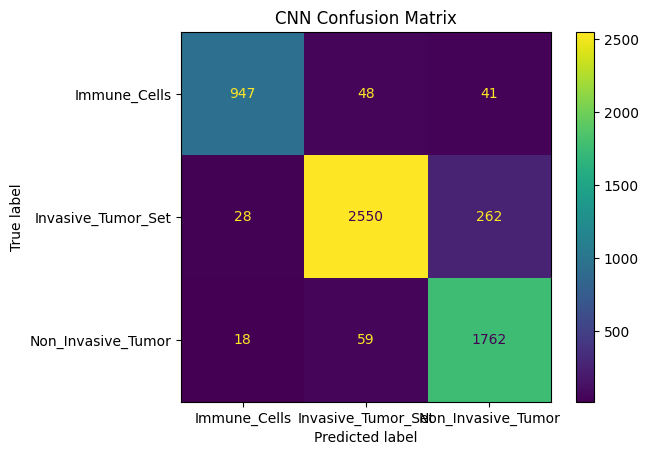

In [9]:
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = le.classes_)

cm_display.plot()
plt.title("CNN Confusion Matrix")
plt.show()

In [10]:

if torch.cuda.is_available():
    print("CUDA is available")
    # You can proceed to verify GPU properties
else:
    print("CUDA is not available")
    # PyTorch might not be utilizing the AMD GPU


if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0) # 0 is the default device
    print(f"GPU name: {device_name}")
    device_properties = torch.cuda.get_device_properties(0)
    print(device_properties)

CUDA is available
GPU name: AMD Radeon RX 9070 XT
_CudaDeviceProperties(name='AMD Radeon RX 9070 XT', major=12, minor=0, gcnArchName='gfx1201', total_memory=16304MB, multi_processor_count=32, uuid=34663438-3437-3537-6332-333330663936, L2_cache_size=8MB)


## Training using gaussian blurry images

In [12]:
# labels = [folder for folder in os.listdir(FOLDER_PATH)]
labels = ["Immune_Cells_Gaussian_5", "Non_Invasive_Tumor_Gaussian_5", "Invasive_Tumor_Set_Gaussian_5"]
le = LabelEncoder()
numeric_labels = le.fit_transform(labels)
image_names = []
for _ in numeric_labels:
    image_names.append([])

for (dir_path, dir_names, file_names) in os.walk(FOLDER_PATH):
    parent_folder = os.path.basename(dir_path)
    if parent_folder in labels: # Read the subset of dataset to reduce training time 
        for file in file_names:
            image = cv2.imread(os.path.join(dir_path, file))
            if image.shape[0] < 100 and image.shape[1] < 100: #skip the small image, it doesn't give much info
                continue
            numeric_label = le.transform([parent_folder])[0]
            image_names[numeric_label].append(os.path.join(dir_path, file))

    
dataset = ImageDataSet(image_names, transform)

In [13]:
_, subset = train_test_split(list(range(len(dataset))), test_size=0.5, random_state=0)

train_idx, temp_idx = train_test_split(subset, test_size=0.3, random_state=0)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=0)

train_subset = Subset(dataset, train_idx)
val_subset = Subset(dataset, val_idx)
test_subset = Subset(dataset, test_idx)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [14]:
best_val_loss = float('inf')
epoch_no_improvement = 0
best_model_parameters = None


cnn_training_start = time.time()
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss/len(val_loader)
    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_parameters = model.state_dict()
        epoch_no_improvement = 0
    else:
        epoch_no_improvement += 1
        if epoch_no_improvement == patience:
            print(f"No improvement for {patience} epoches. Early stopping.")
            break
cnn_training_end = time.time()

if best_model_parameters is not None:
    model.load_state_dict(best_model_parameters)

Epoch [1/100], Loss: 0.1846
Validation Loss: 0.2258, Accuracy: 92.48%
Epoch [2/100], Loss: 0.0920
Validation Loss: 1.3616, Accuracy: 64.41%
Epoch [3/100], Loss: 0.0634
Validation Loss: 0.3484, Accuracy: 92.41%
Epoch [4/100], Loss: 0.0501
Validation Loss: 0.3635, Accuracy: 93.04%
Epoch [5/100], Loss: 0.0443
Validation Loss: 0.2519, Accuracy: 93.33%
Epoch [6/100], Loss: 0.0339
Validation Loss: 0.4167, Accuracy: 88.01%
Epoch [7/100], Loss: 0.0316
Validation Loss: 0.2842, Accuracy: 92.25%
Epoch [8/100], Loss: 0.0311
Validation Loss: 0.3213, Accuracy: 93.33%
Epoch [9/100], Loss: 0.0234
Validation Loss: 0.2959, Accuracy: 93.53%
Epoch [10/100], Loss: 0.0262
Validation Loss: 0.8554, Accuracy: 80.58%
Epoch [11/100], Loss: 0.0221
Validation Loss: 0.4358, Accuracy: 92.00%
No improvement for 10 epoches. Early stopping.


In [15]:
torch.save(model.state_dict(), 'CNN_model.pth')

In [16]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# print(classification_report(y_true, y_pred, target_names=["Tumor", "Immune"]))
pretrained_cnn_accuracy = accuracy_score(y_true, y_pred)
print(pretrained_cnn_accuracy)

0.925984251968504


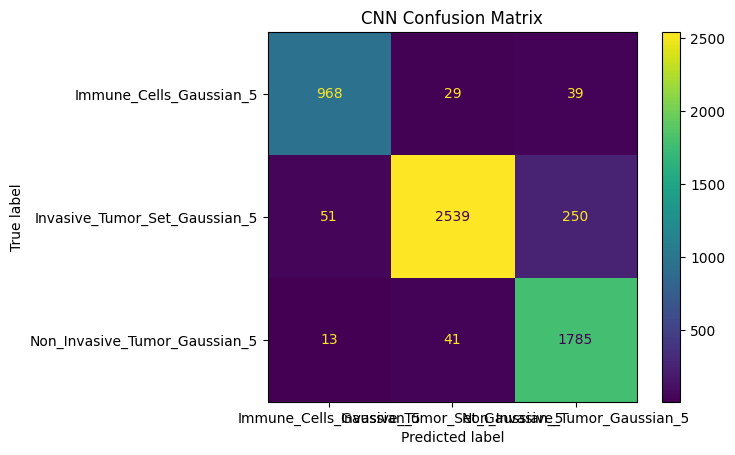

In [17]:
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = le.classes_)

cm_display.plot()
plt.title("CNN Confusion Matrix")
plt.show()

## Training using Median blurry images

In [ ]:
# labels = [folder for folder in os.listdir(FOLDER_PATH)]
labels = ["Immune_Cells_Median_5", "Non_Invasive_Tumor_Median_5", "Invasive_Tumor_Set_Median_5"]
le = LabelEncoder()
numeric_labels = le.fit_transform(labels)
image_names = []
for _ in numeric_labels:
    image_names.append([])

for (dir_path, dir_names, file_names) in os.walk(FOLDER_PATH):
    parent_folder = os.path.basename(dir_path)
    if parent_folder in labels: # Read the subset of dataset to reduce training time 
        for file in file_names:
            image = cv2.imread(os.path.join(dir_path, file))
            if image.shape[0] < 100 and image.shape[1] < 100: #skip the small image, it doesn't give much info
                continue
            numeric_label = le.transform([parent_folder])[0]
            image_names[numeric_label].append(os.path.join(dir_path, file))

    
dataset = ImageDataSet(image_names, transform)

In [ ]:
_, subset = train_test_split(list(range(len(dataset))), test_size=0.5, random_state=0)

train_idx, temp_idx = train_test_split(subset, test_size=0.3, random_state=0)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=0)

train_subset = Subset(dataset, train_idx)
val_subset = Subset(dataset, val_idx)
test_subset = Subset(dataset, test_idx)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [ ]:
best_val_loss = float('inf')
epoch_no_improvement = 0
best_model_parameters = None


cnn_training_start = time.time()
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss/len(val_loader)
    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_parameters = model.state_dict()
        epoch_no_improvement = 0
    else:
        epoch_no_improvement += 1
        if epoch_no_improvement == patience:
            print(f"No improvement for {patience} epoches. Early stopping.")
            break
cnn_training_end = time.time()

if best_model_parameters is not None:
    model.load_state_dict(best_model_parameters)

In [ ]:
torch.save(model.state_dict(), 'CNN_model.pth')

In [ ]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# print(classification_report(y_true, y_pred, target_names=["Tumor", "Immune"]))
pretrained_cnn_accuracy = accuracy_score(y_true, y_pred)
print(pretrained_cnn_accuracy)

In [ ]:
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = le.classes_)

cm_display.plot()
plt.title("CNN Confusion Matrix")
plt.show()